<a href="https://colab.research.google.com/github/steflhermitte/EO-Notebooks/blob/master/RemoteSensing%2BBigData/RSBS_Notebook4_GEEinPython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" width="200" align='right'>](https://www.tudelft.nl/citg/over-faculteit/afdelingen/geoscience-remote-sensing/staff/scientific-staff/dr-stef-lhermitte)


# GEE in python 
*Created by Stef Lhermitte (s.lhermitte at tudelft.nl / [@steflhermitte](https://twitter.com/StefLhermitte) | www.earthmapps.io)*

*with inspiration and fragments from:*

 *  [geemap](http://www.geemap.org)
 *  [eemont](https://github.com/davemlz/eemont)
 *  [wxee](https://github.com/aazuspan/wxee)

[![Twitter](https://img.shields.io/twitter/url/https/twitter.com/cloudposse.svg?style=social&label=%20%40steflhermitte)](https://twitter.com/steflhermitte)


## Before you start
Before starting this notebook make you need to install the necessary packages. For your local computer, you only need to install the packages once and you won't need the next cell. For Colab, you need to run the following installation steps every time you start a new notebook and restart the environment afterwards. 

In [ ]:
# You need to install them once locally and every time in colab
!pip install geemap
!pip install wxee
!pip install eemont

In [1]:
from google.colab import output
output.enable_custom_widget_manager()

## Load packages + authenticate

In [2]:
import ee
import geemap
import eemont
import wxee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=zWAeMsVwFN_KD--r5hyFKtzNXxl14eYJ5iygzbGBizE&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWgurlzZMOXZFdF2W-YZb4uYWJMN8njlvitJLwGDBCEuluOqXH_lc3A

Successfully saved authorization token.


# Geemap add external data

In [13]:
Map = geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [14]:
# Visualize GEE data
landsat7 = ee.Image('LE7_TOA_5YEAR/1999_2003') \
    .select([0, 1, 2, 3, 4, 6])
landsat_vis = {
    'bands': ['B4', 'B3', 'B2'], 
    'gamma': 1.4
}
Map.addLayer(landsat7, landsat_vis, "LE7_TOA_5YEAR/1999_2003")

hyperion = ee.ImageCollection('EO1/HYPERION') \
    .filter(ee.Filter.date('2016-01-01', '2017-03-01'));
hyperion_vis = {
  'min': 1000.0,
  'max': 14000.0,
  'gamma': 2.5,
}
Map.addLayer(hyperion, hyperion_vis, 'EO1/HYPERION');

You can also add local vector files. For example, a dataset of all the countries as a shp-file ([Download it here](https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/countries)), which we downloaded and added to the folder `sample_data`

In [15]:
# Add local vector files
countries_shp = '/content/sample_data/CNTR_BN_60M_2020_4326.shp'
countries = geemap.shp_to_ee(countries_shp)
Map.addLayer(countries, {}, 'Countries')

Similarly you can also load [rasters](https://geemap.org/notebooks/25_load_rasters/), [cloud geotiffs](https://geemap.org/notebooks/38_cloud_geotiff/), etc

# Geemap js to py

In [4]:
js_snippet = """
// Load an image.
var image = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_044034_20140318');

// Define the visualization parameters.
var vizParams = {
  bands: ['B5', 'B4', 'B3'],
  min: 0,
  max: 0.5,
  gamma: [0.95, 1.1, 1]
};

// Center the map and display the image.
Map.setCenter(-122.1899, 37.5010, 10); // San Francisco Bay
Map.addLayer(image, vizParams, 'false color composite');

"""

In [8]:
geemap.js_snippet_to_pynb(js_snippet, add_new_cell=True, import_ee=True, import_geemap=True, show_map=True)

AttributeError: ignored

# Eemont processing

In [ ]:
point = ee.Geometry.PointFromQuery('Cali, Colombia',user_agent = 'eemont-example') # Extended constructor

S2 = (ee.ImageCollection('COPERNICUS/S2_SR')
    .filterBounds(point)
    .closest('2020-10-15') # Extended (pre-processing)
    .maskClouds(prob = 70) # Extended (pre-processing)
    .scaleAndOffset() # Extended (pre-processing)
    .spectralIndices(['NDVI','NDWI','BAIS2'])) # Extended (processing)
print(S2.first())

# Geemap export

### Export an image

In [17]:
image = ee.Image('LE7_TOA_5YEAR/1999_2003')
filename = 'landsat.tif'

In [16]:
# Draw any shapes on the map using the Drawing tools before executing this code block
feature = Map.draw_last_feature

if feature is None:
    geom = ee.Geometry.Polygon([[[-115.413031, 35.889467],
    [-115.413031, 36.543157],
    [-114.034328, 36.543157],
    [-114.034328, 35.889467],
    [-115.413031, 35.889467]]])
    feature = ee.Feature(geom, {})

roi = feature.geometry()

In [18]:
image = image.clip(roi).unmask()

geemap.ee_export_image(image, filename=filename, scale=90, region=roi, file_per_band=False)

Generating URL ...
Please wait ...
Data downloaded to /content/landsat.tif


In [20]:
image = image.clip(roi).unmask()
geemap.ee_export_image(image, filename=filename, scale=90, region=roi, file_per_band=True)

Generating URL ...
Please wait ...
Data downloaded to /content


### Export an image collection

In [21]:
loc = ee.Geometry.Point(-99.2222, 46.7816)
collection = ee.ImageCollection('USDA/NAIP/DOQQ') \
    .filterBounds(loc) \
    .filterDate('2008-01-01', '2020-01-01') \
    .filter(ee.Filter.listContains("system:band_names", "N"))

In [22]:
out_dir = '/content/sample_data/'

In [23]:
print(collection.aggregate_array('system:index').getInfo())

['m_4609915_sw_14_060_20180902_20181213', 'm_4609915_sw_14_060_20190626', 'm_4609915_sw_14_1_20090818', 'm_4609915_sw_14_1_20100629', 'm_4609915_sw_14_1_20120714', 'm_4609915_sw_14_1_20140901', 'm_4609915_sw_14_1_20150926', 'm_4609915_sw_14_h_20160704', 'm_4609915_sw_14_h_20170703']


In [24]:
geemap.ee_export_image_collection(collection, out_dir=out_dir)

Total number of images: 9

Exporting 1/9: m_4609915_sw_14_060_20180902_20181213.tif
Generating URL ...
Please wait ...
Data downloaded to /content/sample_data/m_4609915_sw_14_060_20180902_20181213.tif


Exporting 2/9: m_4609915_sw_14_060_20190626.tif
Generating URL ...
Please wait ...
Data downloaded to /content/sample_data/m_4609915_sw_14_060_20190626.tif


Exporting 3/9: m_4609915_sw_14_1_20090818.tif
Generating URL ...
Please wait ...
Data downloaded to /content/sample_data/m_4609915_sw_14_1_20090818.tif


Exporting 4/9: m_4609915_sw_14_1_20100629.tif
Generating URL ...
Please wait ...
Data downloaded to /content/sample_data/m_4609915_sw_14_1_20100629.tif


Exporting 5/9: m_4609915_sw_14_1_20120714.tif
Generating URL ...
Please wait ...
Data downloaded to /content/sample_data/m_4609915_sw_14_1_20120714.tif


Exporting 6/9: m_4609915_sw_14_1_20140901.tif
Generating URL ...
Please wait ...
Data downloaded to /content/sample_data/m_4609915_sw_14_1_20140901.tif


Exporting 7/9: m_460991

### Export to numpy

In [27]:
import numpy as np
import matplotlib.pyplot as plt

img = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_038029_20180810') \
  .select(['B4', 'B5', 'B6'])

aoi = ee.Geometry.Polygon(
  [[[-110.8, 44.7],
    [-110.8, 44.6],
    [-110.6, 44.6],
    [-110.6, 44.7]]], None, False)

rgb_img = geemap.ee_to_numpy(img, region=aoi)
print(rgb_img.shape)

(373, 531, 3)


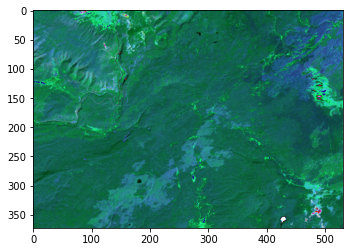

In [28]:
# Scale the data to [0, 255] to show as an RGB image. 
# Adapted from https://bit.ly/2XlmQY8. Credits to Justin Braaten
rgb_img_test = (255*((rgb_img[:, :, 0:3] - 100)/3500)).astype('uint8')
plt.imshow(rgb_img_test)
plt.show()

# Wxee

In [31]:
a = ee.ImageCollection("IDAHO_EPSCOR/GRIDMET").filterDate('2012-1-1','2012-1-10').wx.to_xarray()
print(a)

Requesting data:   0%|          | 0/9 [00:00<?, ?it/s]

In [33]:
ee.ImageCollection("IDAHO_EPSCOR/GRIDMET").filterDate('2012-1-1','2012-1-10').wx.to_tif()

Requesting data:   0%|          | 0/9 [00:00<?, ?it/s]

['./IDAHO_EPSCOR_GRIDMET_20120101.time.20120101T060000.tif',
 './IDAHO_EPSCOR_GRIDMET_20120102.time.20120102T060000.tif',
 './IDAHO_EPSCOR_GRIDMET_20120103.time.20120103T060000.tif',
 './IDAHO_EPSCOR_GRIDMET_20120104.time.20120104T060000.tif',
 './IDAHO_EPSCOR_GRIDMET_20120105.time.20120105T060000.tif',
 './IDAHO_EPSCOR_GRIDMET_20120106.time.20120106T060000.tif',
 './IDAHO_EPSCOR_GRIDMET_20120107.time.20120107T060000.tif',
 './IDAHO_EPSCOR_GRIDMET_20120108.time.20120108T060000.tif',
 './IDAHO_EPSCOR_GRIDMET_20120109.time.20120109T060000.tif']

In [34]:
ee.ImageCollection("IDAHO_EPSCOR/GRIDMET").filterDate('2012-1-1','2012-1-10').wx.to_xarray(path="/content/gridmet.nc")

Requesting data:   0%|          | 0/9 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:  (time: 9, x: 59, y: 26)
Coordinates:
  * time     (time) datetime64[ns] 2012-01-01T06:00:00 ... 2012-01-09T06:00:00
  * y        (y) float64 49.5 48.5 47.5 46.5 45.5 ... 28.5 27.5 26.5 25.5 24.5
  * x        (x) float64 -124.5 -123.5 -122.5 -121.5 ... -69.5 -68.5 -67.5 -66.5
Data variables: (12/16)
    pr       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    rmax     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    rmin     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    sph      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    srad     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    th       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    ...       ...
    eto      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    bi       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    fm100    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    fm1000   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    etr      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    vpd      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    transform:               (1.0, 0.0, -125.0, 0.0, -1.0, 50.0)
    crs:                     +init=epsg:4326
    res:                     (1.0, 1.0)
    is_tiled:                1
    nodatavals:              (-32768.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

# Eemont export

In [38]:
f1 = ee.Feature(ee.Geometry.Point([3.984770,48.767221]).buffer(50),{'ID':'A'})
f2 = ee.Feature(ee.Geometry.Point([4.101367,48.748076]).buffer(50),{'ID':'B'})
fc = ee.FeatureCollection([f1,f2])

S2 = (ee.ImageCollection('COPERNICUS/S2_SR')
   .filterBounds(fc)
   .filterDate('2020-01-01','2021-01-01')
   .maskClouds()
   .scale()
   .index(['EVI','NDVI']))

# By Region
ts = S2.getTimeSeriesByRegion(reducer = [ee.Reducer.mean(),ee.Reducer.median()],
                              geometry = fc,
                              bands = ['EVI','NDVI'],
                              scale = 10)

# By Regions
ts2 = S2.getTimeSeriesByRegions(reducer = [ee.Reducer.mean(),ee.Reducer.median()],
                               collection = fc,
                               bands = ['EVI','NDVI'],
                               scale = 10)

In [40]:
print(ts)

ee.FeatureCollection({
  "functionInvocationValue": {
    "functionName": "Collection.map",
    "arguments": {
      "baseAlgorithm": {
        "functionDefinitionValue": {
          "argumentNames": [
            "_MAPPING_VAR_0_0"
          ],
          "body": {
            "functionInvocationValue": {
              "functionName": "If",
              "arguments": {
                "condition": {
                  "functionInvocationValue": {
                    "functionName": "Number.eq",
                    "arguments": {
                      "left": {
                        "functionInvocationValue": {
                          "functionName": "List.size",
                          "arguments": {
                            "list": {
                              "functionInvocationValue": {
                                "functionName": "Element.propertyNames",
                                "arguments": {
                                  "element": {
                     